Notebook 03: Feature Engineering

---

# 03 - Feature Engineering

## Sistema Inteligente de Retenção de Clientes

**Autor:** Ivan  
**Dataset:** Telco Customer Churn (analisado no Notebook 02)  
**Objetivo:** Criar, transformar e preparar features para modelagem preditiva

---

### Estrutura do Notebook

1. Criação de Features Derivadas
2. Encoding de Variáveis Categóricas
3. Tratamento de Variáveis Numéricas
4. Feature Selection
5. Balanceamento de Classes
6. Divisão Treino/Teste
7. Exportação dos Dados Preparados

## 1. Configuração Inicial

----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
from pathlib import Path
import pickle

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 2. Carregamento dos Dados

----

In [2]:
# Carregar dados com segmentos criados no Notebook 02
"""
DATA_PATH = Path("../data/processed/churn_data_with_segments.csv")
df = pd.read_csv(DATA_PATH)
"""

df = pd.read_csv("churn_data_with_segments.csv")


print("="*80)
print("DATASET CARREGADO")
print("="*80)
print(f"\nDimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"\nPrimeiras linhas:\n")
display(df.head())

DATASET CARREGADO

Dimensões: 7,043 linhas × 23 colunas

Primeiras linhas:



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure_Segment,Charges_Segment
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Novo (0-12 meses),Baixo (≤R$35)
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Estabelecido (25-48 meses),Médio (R$35-70)
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Novo (0-12 meses),Médio (R$35-70)
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Estabelecido (25-48 meses),Médio (R$35-70)
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Novo (0-12 meses),Alto (>R$70)


## 3. Análise Inicial das Features

----

### Tipos de dados:

In [3]:
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
Tenure_Segment       object
Charges_Segment      object
dtype: object


### Resumo:

In [4]:
print(f"  • Variáveis numéricas: {df.select_dtypes(include=np.number).shape[1]}")
print(f"  • Variáveis categóricas: {df.select_dtypes(include='object').shape[1]}")

  • Variáveis numéricas: 4
  • Variáveis categóricas: 19


### Separando features e target:

In [5]:
target_col = 'Churn'
id_col = 'customerID'

print(f"\nVariável alvo: {target_col}")
print(f"Coluna ID: {id_col}")


Variável alvo: Churn
Coluna ID: customerID


## 4. Criação de Features Derivadas

Criando novas features baseadas em conhecimento de negócio e insights do EDA.

---

### 4.1 Features Financeiras

---

#### 1. Valor médio por mês (TotalCharges / tenure)

In [6]:
# Evitar divisão por zero
df['AvgChargesPerMonth'] = df.apply(
    lambda row: row['TotalCharges'] / row['tenure'] if row['tenure'] > 0 else row['MonthlyCharges'],
    axis=1
)

#### 2. Diferença entre MonthlyCharges e média



In [7]:
df['ChargesDifference'] = df['MonthlyCharges'] - df['AvgChargesPerMonth']

#### 3. Razão TotalCharges / MonthlyCharges (indica tempo de relacionamento)



In [8]:
df['ChargesRatio'] = df.apply(
    lambda row: row['TotalCharges'] / row['MonthlyCharges'] if row['MonthlyCharges'] > 0 else 0,
    axis=1
)

#### 4. Categorização de valor do cliente (CLV simplificado)


In [9]:

# CLV = MonthlyCharges * tenure esperado (assumindo 24 meses)
df['EstimatedCLV'] = df['MonthlyCharges'] * 24

#### 5. Flag de cliente de alto valor

In [10]:
df['HighValueCustomer'] = (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)).astype(int)

#### Features financeiras criadas:

In [11]:
print("  • AvgChargesPerMonth")
print("  • ChargesDifference")
print("  • ChargesRatio")
print("  • EstimatedCLV")
print("  • HighValueCustomer")

  • AvgChargesPerMonth
  • ChargesDifference
  • ChargesRatio
  • EstimatedCLV
  • HighValueCustomer


#### Visualizando Features financeiras

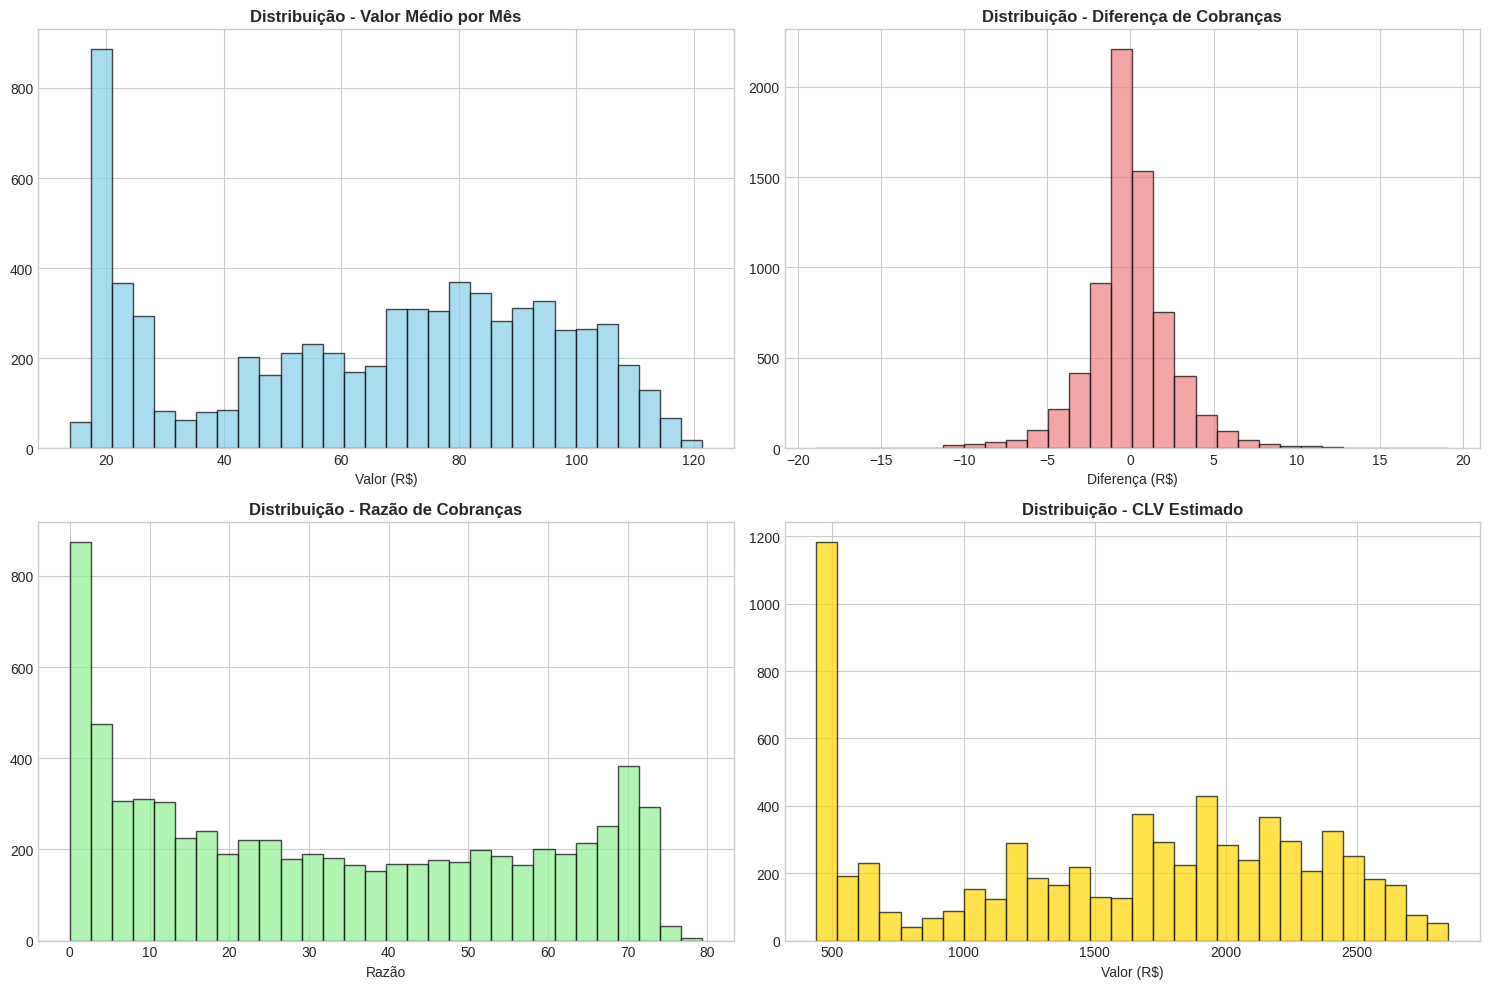

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['AvgChargesPerMonth'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribuição - Valor Médio por Mês', fontweight='bold')
axes[0, 0].set_xlabel('Valor (R$)')

axes[0, 1].hist(df['ChargesDifference'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribuição - Diferença de Cobranças', fontweight='bold')
axes[0, 1].set_xlabel('Diferença (R$)')

axes[1, 0].hist(df['ChargesRatio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribuição - Razão de Cobranças', fontweight='bold')
axes[1, 0].set_xlabel('Razão')

axes[1, 1].hist(df['EstimatedCLV'], bins=30, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribuição - CLV Estimado', fontweight='bold')
axes[1, 1].set_xlabel('Valor (R$)')

plt.tight_layout()
plt.show()


### 4.2 Features de Tenure (Tempo de Relacionamento)

---

#### 1. Categorização de tenure em grupos

In [13]:
def categorize_tenure_detailed(tenure):
    if tenure <= 6:
        return 'Very_New'
    elif tenure <= 12:
        return 'New'
    elif tenure <= 24:
        return 'Intermediate'
    elif tenure <= 48:
        return 'Established'
    else:
        return 'Veteran'

df['TenureGroup'] = df['tenure'].apply(categorize_tenure_detailed)

#### 2. Flag de cliente novo (primeiros 12 meses - período crítico)


In [14]:
df['IsNewCustomer'] = (df['tenure'] <= 12).astype(int)

#### 3. Flag de cliente veterano (mais de 4 anos)





In [15]:
df['IsVeteran'] = (df['tenure'] > 48).astype(int)

#### 4. Tenure em anos (para facilitar interpretação)

In [16]:
df['TenureYears'] = df['tenure'] / 12

#### 5. Quartil de tenure



In [17]:
df['TenureQuartile'] = pd.qcut(df['tenure'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

#### Features de tenure criadas:

In [18]:
print("  • TenureGroup")
print("  • IsNewCustomer")
print("  • IsVeteran")
print("  • TenureYears")
print("  • TenureQuartile")

  • TenureGroup
  • IsNewCustomer
  • IsVeteran
  • TenureYears
  • TenureQuartile


#### Visualizando Features de tenure

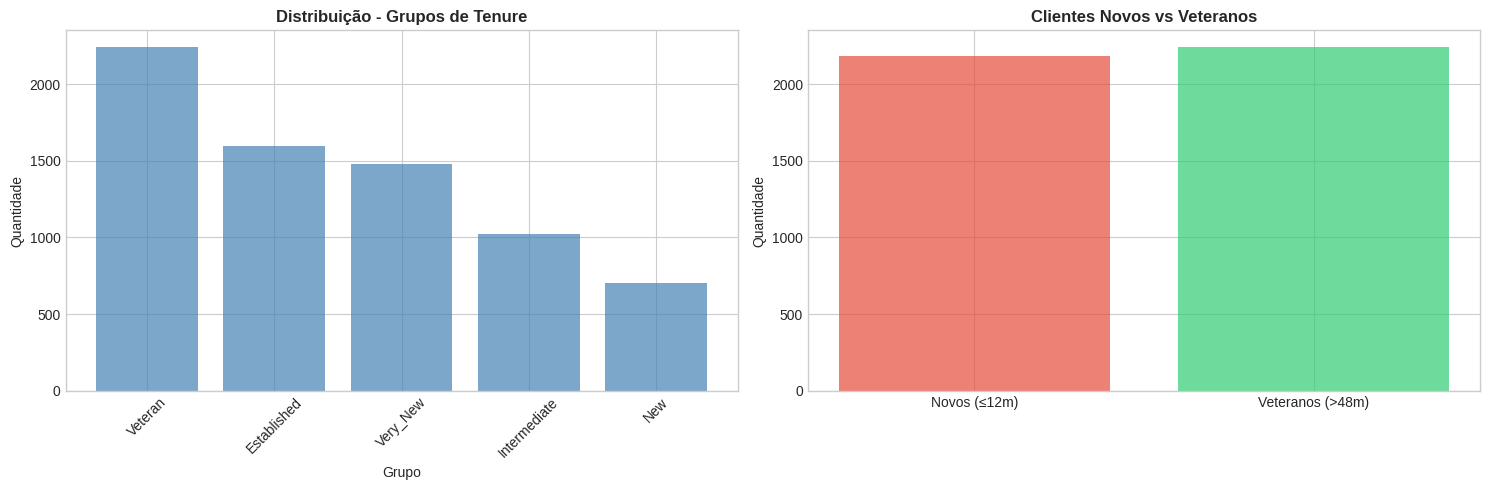

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

tenure_group_counts = df['TenureGroup'].value_counts()
axes[0].bar(tenure_group_counts.index, tenure_group_counts.values, color='steelblue', alpha=0.7)
axes[0].set_title('Distribuição - Grupos de Tenure', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Grupo')
axes[0].set_ylabel('Quantidade')
axes[0].tick_params(axis='x', rotation=45)

new_vs_veteran = df[['IsNewCustomer', 'IsVeteran']].sum()
axes[1].bar(['Novos (≤12m)', 'Veteranos (>48m)'], new_vs_veteran.values,
            color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[1].set_title('Clientes Novos vs Veteranos', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()


### 4.3 Features de Serviços (Contagem e Combinações)

----

#### Criando a Lista de serviços

In [20]:
service_columns = [
    'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

#### 1. Contagem total de serviços contratados


In [21]:
df['TotalServices'] = df[service_columns].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1
)

#### 2. Flag de cliente com muitos serviços
**negrito**

In [22]:
df['HasManyServices'] = (df['TotalServices'] >= 4).astype(int)



#### 3. Flag de cliente sem nenhum serviço adicional


In [23]:
df['NoAdditionalServices'] = (df['TotalServices'] == 0).astype(int)



#### 4. Serviços de segurança (combinação crítica identificada no EDA)


In [24]:
security_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df['SecurityServicesCount'] = df[security_services].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1
)

#### 5. Flag de cliente sem serviços de segurança (alto risco)


In [25]:
df['NoSecurityServices'] = (df['SecurityServicesCount'] == 0).astype(int)


#### 6. Serviços de streaming


In [26]:
streaming_services = ['StreamingTV', 'StreamingMovies']
df['StreamingServicesCount'] = df[streaming_services].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1
)

#### 7. Flag de cliente com internet mas sem serviços adicionais (risco)

In [27]:
df['InternetWithoutServices'] = (
    (df['InternetService'] != 'No') & (df['TotalServices'] <= 1)
).astype(int)

#### Features de serviços criadas:

In [28]:
print("  • TotalServices")
print("  • HasManyServices")
print("  • NoAdditionalServices")
print("  • SecurityServicesCount")
print("  • NoSecurityServices")
print("  • StreamingServicesCount")
print("  • InternetWithoutServices")

  • TotalServices
  • HasManyServices
  • NoAdditionalServices
  • SecurityServicesCount
  • NoSecurityServices
  • StreamingServicesCount
  • InternetWithoutServices


#### Visualizando as Features de Serviços

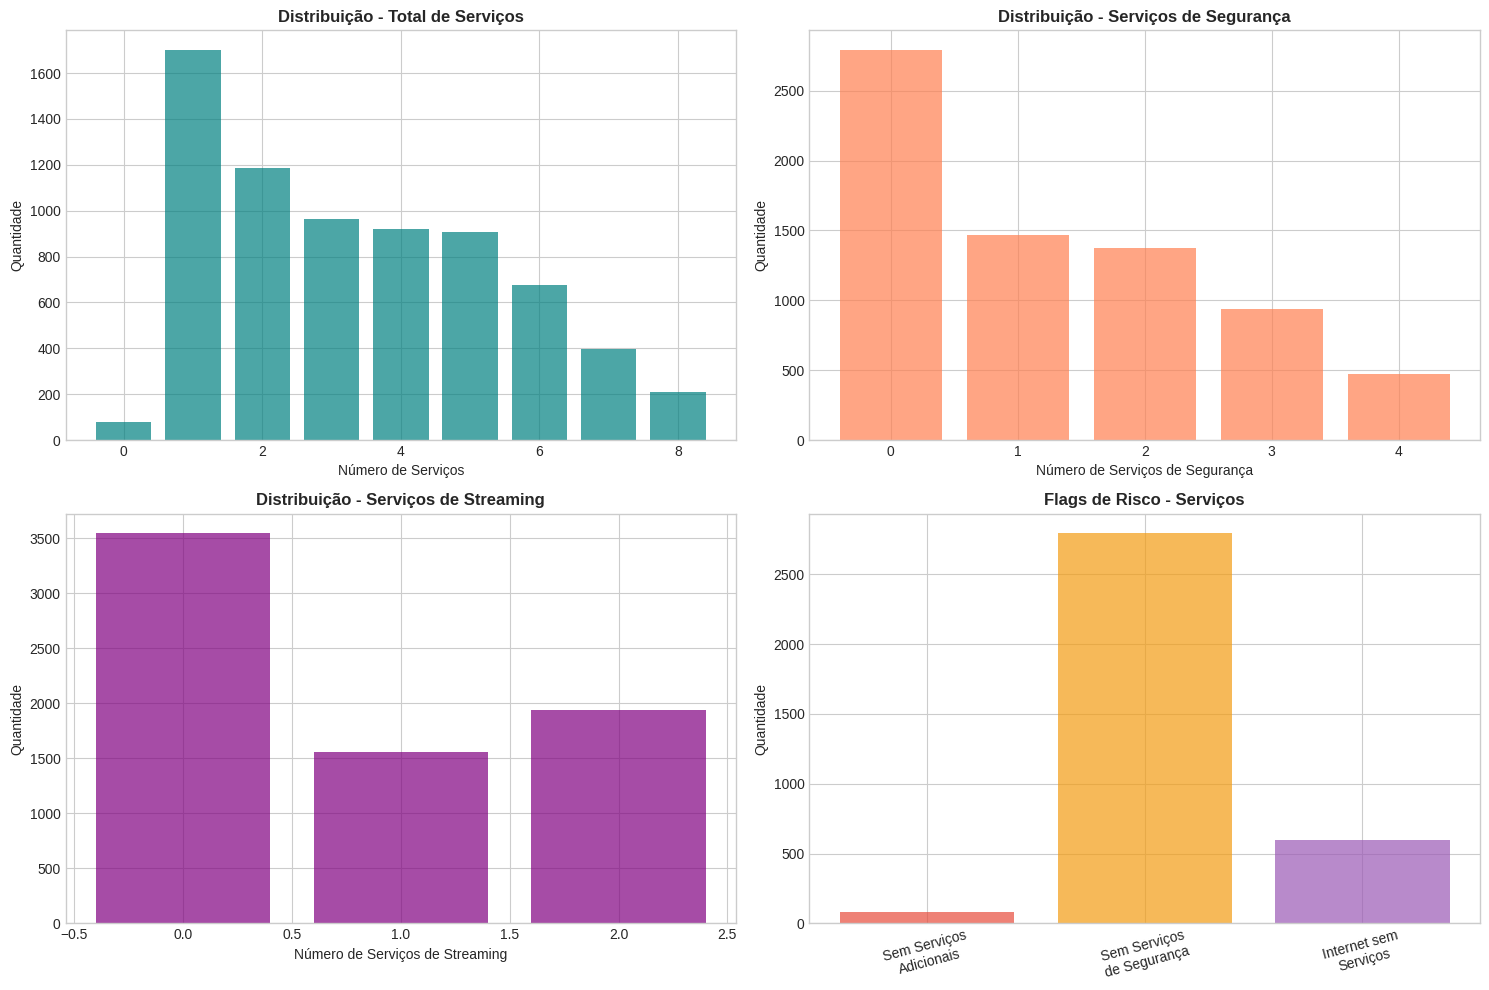

In [29]:
# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total de serviços
services_dist = df['TotalServices'].value_counts().sort_index()
axes[0, 0].bar(services_dist.index, services_dist.values, color='teal', alpha=0.7)
axes[0, 0].set_title('Distribuição - Total de Serviços', fontweight='bold')
axes[0, 0].set_xlabel('Número de Serviços')
axes[0, 0].set_ylabel('Quantidade')

# Serviços de segurança
security_dist = df['SecurityServicesCount'].value_counts().sort_index()
axes[0, 1].bar(security_dist.index, security_dist.values, color='coral', alpha=0.7)
axes[0, 1].set_title('Distribuição - Serviços de Segurança', fontweight='bold')
axes[0, 1].set_xlabel('Número de Serviços de Segurança')
axes[0, 1].set_ylabel('Quantidade')

# Serviços de streaming
streaming_dist = df['StreamingServicesCount'].value_counts().sort_index()
axes[1, 0].bar(streaming_dist.index, streaming_dist.values, color='purple', alpha=0.7)
axes[1, 0].set_title('Distribuição - Serviços de Streaming', fontweight='bold')
axes[1, 0].set_xlabel('Número de Serviços de Streaming')
axes[1, 0].set_ylabel('Quantidade')

# Flags importantes
flags_data = {
    'Sem Serviços\nAdicionais': df['NoAdditionalServices'].sum(),
    'Sem Serviços\nde Segurança': df['NoSecurityServices'].sum(),
    'Internet sem\nServiços': df['InternetWithoutServices'].sum()
}
axes[1, 1].bar(flags_data.keys(), flags_data.values(), color=['#e74c3c', '#f39c12', '#9b59b6'], alpha=0.7)
axes[1, 1].set_title('Flags de Risco - Serviços', fontweight='bold')
axes[1, 1].set_ylabel('Quantidade')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 4.4 Features de Contrato e Pagamento

Criando features de contrato e pagamento

----

#### 1. Flag de contrato mensal (maior risco identificado no EDA)

In [30]:
df['IsMonthlyContract'] = (df['Contract'] == 'Month-to-month').astype(int)

#### 2. Flag de contrato longo (proteção contra churn)

In [31]:
df['IsLongTermContract'] = (df['Contract'].isin(['One year', 'Two year'])).astype(int)

#### 3. Flag de pagamento eletrônico (risco)

In [32]:
df['IsElectronicCheck'] = (df['PaymentMethod'] == 'Electronic check').astype(int)

#### 4. Flag de pagamento automático (proteção)

In [33]:
df['IsAutomaticPayment'] = (
    df['PaymentMethod'].isin(['Bank transfer (automatic)', 'Credit card (automatic)'])
).astype(int)

#### 5. Combinação crítica: Contrato mensal + Electronic check (alto risco)

In [34]:
df['HighRiskPaymentContract'] = (
    (df['IsMonthlyContract'] == 1) & (df['IsElectronicCheck'] == 1)
).astype(int)

#### Features de contrato e pagamento criadas

In [35]:
print("  • IsMonthlyContract")
print("  • IsLongTermContract")
print("  • IsElectronicCheck")
print("  • IsAutomaticPayment")
print("  • HighRiskPaymentContract")

  • IsMonthlyContract
  • IsLongTermContract
  • IsElectronicCheck
  • IsAutomaticPayment
  • HighRiskPaymentContract


#### Estatisticas das Features de contrato e pagamento criadas

In [36]:
print(f"  • Contratos mensais: {df['IsMonthlyContract'].sum()} ({df['IsMonthlyContract'].mean()*100:.1f}%)")
print(f"  • Contratos longos: {df['IsLongTermContract'].sum()} ({df['IsLongTermContract'].mean()*100:.1f}%)")
print(f"  • Electronic check: {df['IsElectronicCheck'].sum()} ({df['IsElectronicCheck'].mean()*100:.1f}%)")
print(f"  • Pagamento automático: {df['IsAutomaticPayment'].sum()} ({df['IsAutomaticPayment'].mean()*100:.1f}%)")
print(f"  • Alto risco (mensal + e-check): {df['HighRiskPaymentContract'].sum()} ({df['HighRiskPaymentContract'].mean()*100:.1f}%)")

  • Contratos mensais: 3875 (55.0%)
  • Contratos longos: 3168 (45.0%)
  • Electronic check: 2365 (33.6%)
  • Pagamento automático: 3066 (43.5%)
  • Alto risco (mensal + e-check): 1850 (26.3%)


### 4.5 Features Demográficas Combinadas

Criando Features Demográficas Combinadas

---

#### 1. Flag de cliente solitário (sem parceiro e sem dependentes - risco)

In [37]:
df['IsAlone'] = (
    (df['Partner'] == 'No') & (df['Dependents'] == 'No')
).astype(int)

#### 2. Flag de família (parceiro + dependentes - proteção)

In [38]:
df['HasFamily'] = (
    (df['Partner'] == 'Yes') & (df['Dependents'] == 'Yes')
).astype(int)

#### 3. Combinação crítica: Senior + Alone (alto risco)

In [39]:
df['SeniorAlone'] = (
    (df['SeniorCitizen'] == 1) & (df['IsAlone'] == 1)
).astype(int)

#### 4. Score demográfico de risco (0-3)

In [40]:
df['DemographicRiskScore'] = (
    df['SeniorCitizen'] +
    df['IsAlone'].astype(int) +
    (df['Partner'] == 'No').astype(int)
)

#### Features demográficas combinadas criadas

In [41]:
print("  • IsAlone")
print("  • HasFamily")
print("  • SeniorAlone")
print("  • DemographicRiskScore")

  • IsAlone
  • HasFamily
  • SeniorAlone
  • DemographicRiskScore


#### Visualizanndo as Features demográficas combinadas

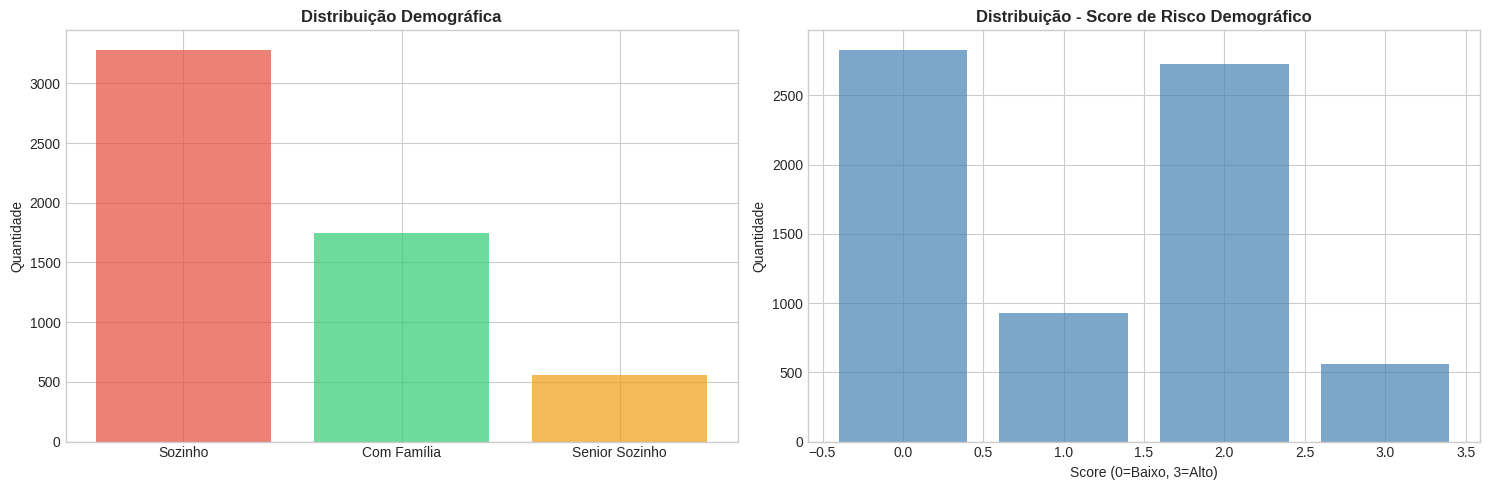

In [42]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribuição de clientes sozinhos vs com família
demo_dist = pd.Series({
    'Sozinho': df['IsAlone'].sum(),
    'Com Família': df['HasFamily'].sum(),
    'Senior Sozinho': df['SeniorAlone'].sum()
})
axes[0].bar(demo_dist.index, demo_dist.values, color=['#e74c3c', '#2ecc71', '#f39c12'], alpha=0.7)
axes[0].set_title('Distribuição Demográfica', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Quantidade')

# Score de risco demográfico
risk_score_dist = df['DemographicRiskScore'].value_counts().sort_index()
axes[1].bar(risk_score_dist.index, risk_score_dist.values, color='steelblue', alpha=0.7)
axes[1].set_title('Distribuição - Score de Risco Demográfico', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Score (0=Baixo, 3=Alto)')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### 4.6 Feature de Risco Composto

Criando Features de Risco Composto

----

#### Score de risco baseado nos principais fatores identificados no EDA

- Peso maior para fatores mais críticos

In [43]:
risk_factors = {
    'IsMonthlyContract': 3,        # Peso 3 (fator mais crítico)
    'IsNewCustomer': 2,             # Peso 2
    'NoSecurityServices': 2,        # Peso 2
    'IsElectronicCheck': 2,         # Peso 2
    'InternetWithoutServices': 1,   # Peso 1
    'IsAlone': 1,                   # Peso 1
    'SeniorCitizen': 1              # Peso 1
}

df['CompositeRiskScore'] = sum(df[col] * weight for col, weight in risk_factors.items())

# Normalizar para 0-10
max_score = sum(risk_factors.values())
df['CompositeRiskScore_Normalized'] = (df['CompositeRiskScore'] / max_score) * 10

# Categorizar em níveis de risco
def categorize_risk(score):
    if score <= 3:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Critical'

df['RiskLevel'] = df['CompositeRiskScore_Normalized'].apply(categorize_risk)

#### Features de risco composto criadas

In [44]:
print("  • CompositeRiskScore")
print("  • CompositeRiskScore_Normalized (0-10)")
print("  • RiskLevel (Low/Medium/High/Critical)")

  • CompositeRiskScore
  • CompositeRiskScore_Normalized (0-10)
  • RiskLevel (Low/Medium/High/Critical)


#### Visualizando as Features de risco composto

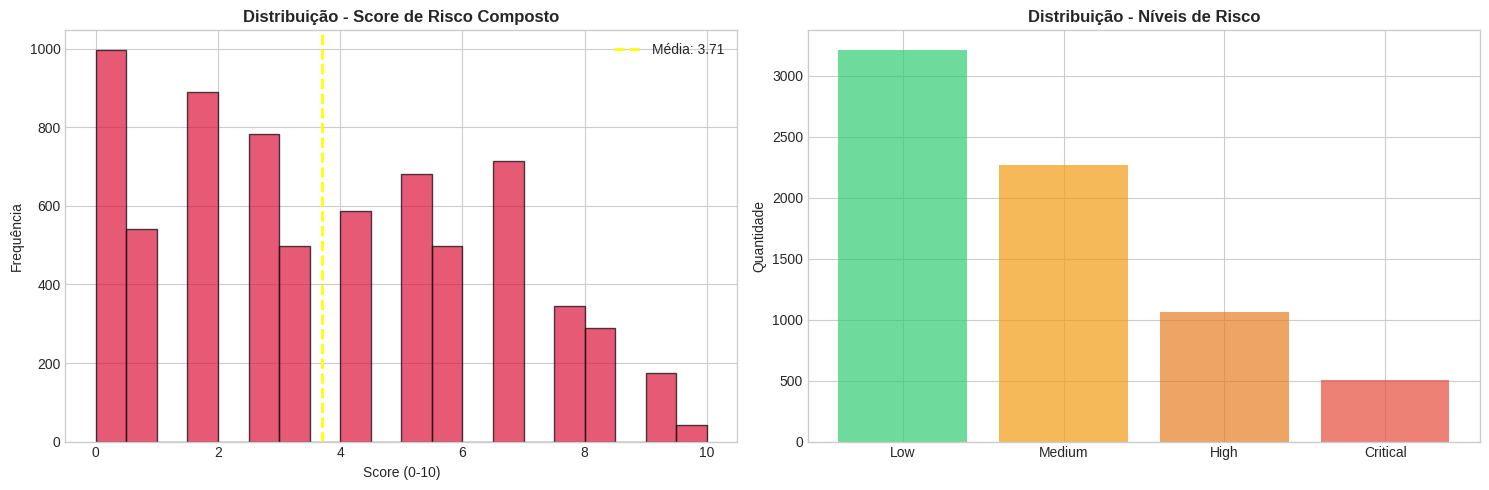

In [45]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribuição do score normalizado
axes[0].hist(df['CompositeRiskScore_Normalized'], bins=20, color='crimson', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuição - Score de Risco Composto', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Score (0-10)')
axes[0].set_ylabel('Frequência')
axes[0].axvline(df['CompositeRiskScore_Normalized'].mean(), color='yellow',
                linestyle='--', linewidth=2, label=f'Média: {df["CompositeRiskScore_Normalized"].mean():.2f}')
axes[0].legend()

# Distribuição por nível de risco
risk_level_counts = df['RiskLevel'].value_counts()
colors_risk = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e67e22', 'Critical': '#e74c3c'}
axes[1].bar(risk_level_counts.index, risk_level_counts.values,
            color=[colors_risk[level] for level in risk_level_counts.index], alpha=0.7)
axes[1].set_title('Distribuição - Níveis de Risco', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

#### Distribuição por Nível de Risco

In [46]:
print(risk_level_counts)

RiskLevel
Low         3210
Medium      2267
High        1059
Critical     507
Name: count, dtype: int64


## 5. Resumo das Features Criadas

----

In [50]:
new_features = [
    # Financeiras
    'AvgChargesPerMonth', 'ChargesDifference', 'ChargesRatio', 'EstimatedCLV', 'HighValueCustomer',
    # Tenure
    'TenureGroup', 'IsNewCustomer', 'IsVeteran', 'TenureYears', 'TenureQuartile',
    # Serviços
    'TotalServices', 'HasManyServices', 'NoAdditionalServices', 'SecurityServicesCount',
    'NoSecurityServices', 'StreamingServicesCount', 'InternetWithoutServices',
    # Contrato e Pagamento
    'IsMonthlyContract', 'IsLongTermContract', 'IsElectronicCheck', 'IsAutomaticPayment',
    'HighRiskPaymentContract',
    # Demográficas
    'IsAlone', 'HasFamily', 'SeniorAlone', 'DemographicRiskScore',
    # Risco Composto
    'CompositeRiskScore', 'CompositeRiskScore_Normalized', 'RiskLevel'
]

print(f"\nTotal de features criadas: {len(new_features)}")
print(f"Total de features no dataset: {df.shape[1]}")

print("\nCategorias de features criadas:\n")
print("  • Financeiras: 5")
print("  • Tenure: 5")
print("  • Serviços: 7")
print("  • Contrato e Pagamento: 5")
print("  • Demográficas: 4")
print("  • Risco Composto: 3")


Total de features criadas: 29
Total de features no dataset: 52

Categorias de features criadas:

  • Financeiras: 5
  • Tenure: 5
  • Serviços: 7
  • Contrato e Pagamento: 5
  • Demográficas: 4
  • Risco Composto: 3


## 6. Encoding de Variáveis Categóricas

---

Vamos preparar as variáveis categóricas para modelagem.

### 6.1 Identificar Variáveis Categóricas

----

In [51]:
# Remover ID e target
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if id_col in categorical_cols:
    categorical_cols.remove(id_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"\nTotal de variáveis categóricas: {len(categorical_cols)}")
print(f"\nVariáveis categóricas:")
for col in categorical_cols:
    print(f"  • {col}: {df[col].nunique()} valores únicos")


Total de variáveis categóricas: 19

Variáveis categóricas:
  • gender: 2 valores únicos
  • Partner: 2 valores únicos
  • Dependents: 2 valores únicos
  • PhoneService: 2 valores únicos
  • MultipleLines: 3 valores únicos
  • InternetService: 3 valores únicos
  • OnlineSecurity: 3 valores únicos
  • OnlineBackup: 3 valores únicos
  • DeviceProtection: 3 valores únicos
  • TechSupport: 3 valores únicos
  • StreamingTV: 3 valores únicos
  • StreamingMovies: 3 valores únicos
  • Contract: 3 valores únicos
  • PaperlessBilling: 2 valores únicos
  • PaymentMethod: 4 valores únicos
  • Tenure_Segment: 4 valores únicos
  • Charges_Segment: 3 valores únicos
  • TenureGroup: 5 valores únicos
  • RiskLevel: 4 valores únicos


### 6.2 Estratégia de Encoding

----

**Decisão:**

- **Label Encoding:** Para variáveis ordinais (ex: TenureGroup, RiskLevel)

- **One-Hot Encoding:** Para variáveis nominais (ex: InternetService, PaymentMethod)

- **Binary Encoding:** Para variáveis binárias (já tratadas como 0/1)

In [52]:
# Criar cópia para encoding
df_encoded = df.copy()

In [53]:
#1. Label Encoding para variáveis ordinais
ordinal_cols = {
    'TenureGroup': ['Very_New', 'New', 'Intermediate', 'Established', 'Veteran'],
    'TenureQuartile': ['Q1', 'Q2', 'Q3', 'Q4'],
    'RiskLevel': ['Low', 'Medium', 'High', 'Critical']
}

for col, order in ordinal_cols.items():
    if col in df_encoded.columns:
        df_encoded[f'{col}_Encoded'] = df_encoded[col].map({val: idx for idx, val in enumerate(order)})
        print(f"  Label Encoding: {col}")

  ✅ Label Encoding: TenureGroup
  ✅ Label Encoding: TenureQuartile
  ✅ Label Encoding: RiskLevel


In [54]:
# 2. One-Hot Encoding para variáveis nominais
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols.keys()]

In [55]:
# Filtrar colunas que ainda existem
nominal_cols = [col for col in nominal_cols if col in df_encoded.columns]

print(f"\n  Aplicando One-Hot Encoding em {len(nominal_cols)} colunas...")

df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True, dtype=int)

print(f"  One-Hot Encoding aplicado")


  Aplicando One-Hot Encoding em 17 colunas...
  One-Hot Encoding aplicado


In [56]:
# 3. Converter target para binário
df_encoded['Churn_Binary'] = (df_encoded[target_col] == 'Yes').astype(int)

print(f"\nEncoding concluído!")
print(f"Dimensões após encoding: {df_encoded.shape}")


Encoding concluído!
Dimensões após encoding: (7043, 70)


## 7. Preparação Final dos Dados

---

### 7.1 Remover Colunas Desnecessárias

In [57]:
# Colunas para remover
cols_to_drop = [
    id_col,                          # ID do cliente
    target_col,                      # Target original (temos Churn_Binary)
    'TenureGroup',                   # Temos TenureGroup_Encoded
    'TenureQuartile',                # Temos TenureQuartile_Encoded
    'RiskLevel',                     # Temos RiskLevel_Encoded
    'Tenure_Segment',                # Redundante com TenureGroup
    'Charges_Segment'                # Redundante com features financeiras
]

In [58]:
# Remover apenas colunas que existem
cols_to_drop = [col for col in cols_to_drop if col in df_encoded.columns]

df_encoded = df_encoded.drop(columns=cols_to_drop)

print(f"{len(cols_to_drop)} colunas removidas")
print(f"Dimensões finais: {df_encoded.shape}")

5 colunas removidas
Dimensões finais: (7043, 65)


### 7.2 Separar Features e Target


In [59]:
# Target
y = df_encoded['Churn_Binary']

# Features (remover target)
X = df_encoded.drop('Churn_Binary', axis=1)

print(f"Separação concluída!")
print(f"  • Features (X): {X.shape}")
print(f"  • Target (y): {y.shape}")
print(f"\n  Distribuição do target:")
print(f"    - Não Churn (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"    - Churn (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

Separação concluída!
  • Features (X): (7043, 64)
  • Target (y): (7043,)

  Distribuição do target:
    - Não Churn (0): 5174 (73.5%)
    - Churn (1): 1869 (26.5%)


### 7.3 Divisão Treino/Teste

In [60]:
# Divisão estratificada (manter proporção de churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [61]:
print(f"Divisão concluída!")
print(f"\nTreino:\n")
print(f"  • Features: {X_train.shape}")
print(f"  • Target: {y_train.shape}")
print(f"  • Churn rate: {y_train.mean()*100:.1f}%")

Divisão concluída!

Treino:

  • Features: (5634, 64)
  • Target: (5634,)
  • Churn rate: 26.5%


In [62]:
print(f"\nTeste:\n")
print(f"  • Features: {X_test.shape}")
print(f"  • Target: {y_test.shape}")
print(f"  • Churn rate: {y_test.mean()*100:.1f}%")


Teste:

  • Features: (1409, 64)
  • Target: (1409,)
  • Churn rate: 26.5%


## 8. Normalização/Padronização

---

Normalizar as features numéricas para melhorar a performance dos modelos.

In [63]:
# Identificar colunas numéricas (excluindo binárias)
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

In [64]:
# Remover colunas binárias (0/1) da normalização
binary_cols = [col for col in numeric_cols if X_train[col].nunique() == 2 and set(X_train[col].unique()).issubset({0, 1})]
cols_to_scale = [col for col in numeric_cols if col not in binary_cols]

print(f"  • Colunas numéricas: {len(numeric_cols)}")
print(f"  • Colunas binárias (não normalizar): {len(binary_cols)}")
print(f"  • Colunas para normalizar: {len(cols_to_scale)}")

  • Colunas numéricas: 63
  • Colunas binárias (não normalizar): 47
  • Colunas para normalizar: 16


In [65]:
# Aplicar StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(f"\nNormalização concluída!")


Normalização concluída!


In [67]:
# Salvar scaler para uso futuro
"""scaler_path = Path("../models/scaler.pkl")"""
scaler_path = Path("scaler.pkl")
scaler_path.parent.mkdir(parents=True, exist_ok=True)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler salvo em: {scaler_path}")

Scaler salvo em: scaler.pkl


## 9. Tratamento de Desbalanceamento

---

Criar versões balanceadas dos dados usando SMOTE.


In [68]:
print(f"Distribuição original:")
print(f"  • Não Churn: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  • Churn: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

Distribuição original:
  • Não Churn: 4139 (73.5%)
  • Churn: 1495 (26.5%)


In [69]:
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42, sampling_strategy=0.8)  # 80% da classe majoritária

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [70]:
print(f"\nSMOTE aplicado!")
print(f"Distribuição após SMOTE:")
print(f"  • Não Churn: {(y_train_balanced == 0).sum()} ({(y_train_balanced == 0).mean()*100:.1f}%)")
print(f"  • Churn: {(y_train_balanced == 1).sum()} ({(y_train_balanced == 1).mean()*100:.1f}%)")


SMOTE aplicado!
Distribuição após SMOTE:
  • Não Churn: 4139 (55.6%)
  • Churn: 3311 (44.4%)


In [71]:
print(f"\nNovos shapes:")
print(f"  • X_train_balanced: {X_train_balanced.shape}")
print(f"  • y_train_balanced: {y_train_balanced.shape}")


Novos shapes:
  • X_train_balanced: (7450, 64)
  • y_train_balanced: (7450,)


## 10. Feature Selection

---

Identificar as features mais importantes usando múltiplos métodos.

### Mutual Information

In [72]:
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 20 features por Mutual Information:")
display(mi_scores_df.head(20))


Top 20 features por Mutual Information:


,Feature,MI_Score
29,CompositeRiskScore_Normalized,0.107
28,CompositeRiskScore,0.099
32,RiskLevel_Encoded,0.088
20,IsLongTermContract,0.086
19,IsMonthlyContract,0.085
6,ChargesRatio,0.073
23,HighRiskPaymentContract,0.068
1,tenure,0.066
11,TenureYears,0.063
31,TenureQuartile_Encoded,0.060


### Visualizando (Mutual Information)

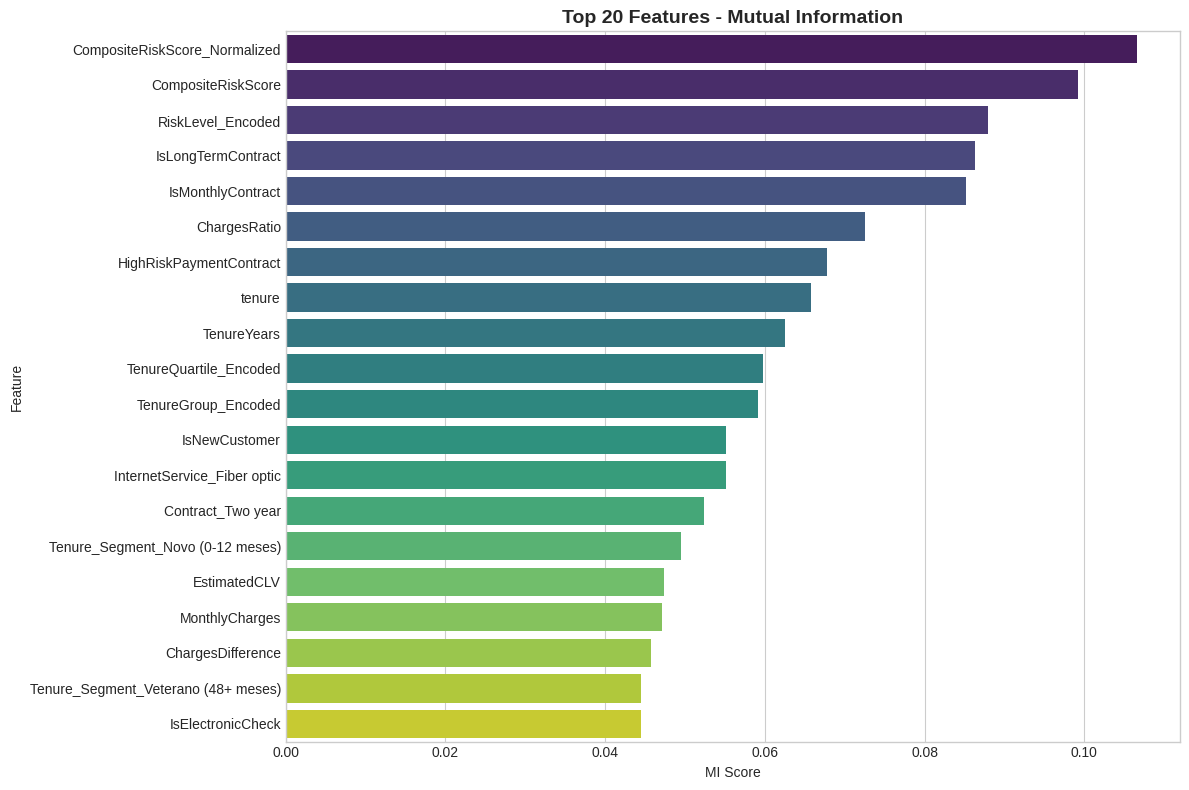

In [73]:
plt.figure(figsize=(12, 8))
top_20_mi = mi_scores_df.head(20)
sns.barplot(x='MI_Score', y='Feature', data=top_20_mi, palette='viridis')
plt.title('Top 20 Features - Mutual Information', fontweight='bold', fontsize=14)
plt.xlabel('MI Score')
plt.tight_layout()
plt.show()

### 10.1 Selecionar Features Finais

In [74]:
# Estratégia: Manter top features por MI + features criadas importantes
top_n_features = 50

# Top features por MI
top_features_mi = mi_scores_df.head(top_n_features)['Feature'].tolist()

In [75]:
# Features criadas importantes (garantir que estejam incluídas)
important_created_features = [
    'CompositeRiskScore_Normalized',
    'TotalServices',
    'SecurityServicesCount',
    'IsMonthlyContract',
    'IsNewCustomer',
    'AvgChargesPerMonth',
    'NoSecurityServices'
]

In [76]:
# Combinar (sem duplicatas)
selected_features = list(set(top_features_mi + important_created_features))

# Filtrar features que existem
selected_features = [f for f in selected_features if f in X_train_scaled.columns]

print(f"{len(selected_features)} features selecionadas")

51 features selecionadas


In [77]:
# Criar datasets com features selecionadas
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\nNovos shapes:")
print(f"  • X_train_selected: {X_train_selected.shape}")
print(f"  • X_test_selected: {X_test_selected.shape}")


Novos shapes:
  • X_train_selected: (5634, 51)
  • X_test_selected: (1409, 51)


## 11. Exportação dos Dados Preparados

---

In [78]:
# Criar diretório se não existir
"""
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)
"""

### 11.1. Dados completos (todas as features)

In [80]:
"""
X_train_scaled.to_csv(processed_dir / "X_train_full.csv", index=False)
X_test_scaled.to_csv(processed_dir / "X_test_full.csv", index=False)
y_train.to_csv(processed_dir / "y_train.csv", index=False, header=['Churn'])
y_test.to_csv(processed_dir / "y_test.csv", index=False, header=['Churn'])
"""

X_train_scaled.to_csv("X_train_full.csv", index=False)
X_test_scaled.to_csv("X_test_full.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=['Churn'])
y_test.to_csv("y_test.csv", index=False, header=['Churn'])

In [81]:
print("Dados completos exportados:")
print(f"  • X_train_full.csv ({X_train_scaled.shape})")
print(f"  • X_test_full.csv ({X_test_scaled.shape})")
print(f"  • y_train.csv ({y_train.shape})")
print(f"  • y_test.csv ({y_test.shape})")

Dados completos exportados:
  • X_train_full.csv ((5634, 64))
  • X_test_full.csv ((1409, 64))
  • y_train.csv ((5634,))
  • y_test.csv ((1409,))


### 11.2. Dados balanceados (SMOTE)

In [82]:
"""
pd.DataFrame(X_train_balanced, columns=X_train_scaled.columns).to_csv(
    processed_dir / "X_train_balanced.csv", index=False
)
pd.DataFrame(y_train_balanced, columns=['Churn']).to_csv(
    processed_dir / "y_train_balanced.csv", index=False
)
"""

pd.DataFrame(X_train_balanced, columns=X_train_scaled.columns).to_csv(
    "X_train_balanced.csv", index=False
)
pd.DataFrame(y_train_balanced, columns=['Churn']).to_csv(
    "y_train_balanced.csv", index=False
)

print("\nDados balanceados exportados:")
print(f"  • X_train_balanced.csv ({X_train_balanced.shape})")
print(f"  • y_train_balanced.csv ({y_train_balanced.shape})")


Dados balanceados exportados:
  • X_train_balanced.csv ((7450, 64))
  • y_train_balanced.csv ((7450,))


### 11.3. Dados com features selecionadas

In [84]:
""""
X_train_selected.to_csv(processed_dir / "X_train_selected.csv", index=False)
X_test_selected.to_csv(processed_dir / "X_test_selected.csv", index=False)
"""

X_train_selected.to_csv("X_train_selected.csv", index=False)
X_test_selected.to_csv("X_test_selected.csv", index=False)

print("\nDados com features selecionadas exportados:")
print(f"  • X_train_selected.csv ({X_train_selected.shape})")
print(f"  • X_test_selected.csv ({X_test_selected.shape})")


Dados com features selecionadas exportados:
  • X_train_selected.csv ((5634, 51))
  • X_test_selected.csv ((1409, 51))


### 11.4. Salvar lista de features selecionadas

In [86]:
""""
with open(processed_dir / "selected_features.txt", 'w') as f:
    f.write('\n'.join(selected_features))
    """

with open("selected_features.txt", 'w') as f:
    f.write('\n'.join(selected_features))

print("\nLista de features selecionadas salva")


Lista de features selecionadas salva


### 11.5. Salvar metadados

In [87]:
metadata = {
    'total_features': X_train_scaled.shape[1],
    'selected_features': len(selected_features),
    'train_samples': X_train_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'train_churn_rate': float(y_train.mean()),
    'test_churn_rate': float(y_test.mean()),
    'balanced_samples': X_train_balanced.shape[0],
    'balanced_churn_rate': float(y_train_balanced.mean())
}

import json
with open("metadata.json", 'w') as f:
  json.dump(metadata, f, indent=4)

"""
with open(processed_dir / "metadata.json", 'w') as f:
  json.dump(metadata, f, indent=4)
"""

print("\nMetadados salvos")


Metadados salvos


## 12. Resumo Final

---

**ESTATÍSTICAS FINAIS:**

1. **FEATURES CRIADAS**:

   • Total de novas features: 29

   • Features após encoding: 64

   • Features selecionadas: 51

2. **DATASETS PREPARADOS**:

   • Treino (completo): (5634, 64)

   • Teste (completo): (1409, 64)

   • Treino (balanceado): (7450, 64)

   • Treino (selecionado): (5634, 51)

3. **DISTRIBUIÇÃO DO TARGET**:

   • Treino original: 26.5% churn

   • Teste: 26.5% churn

   • Treino balanceado: 44.4% churn

4. **TRANSFORMAÇÕES APLICADAS**:

   • Criação de 29 novas features

   • Label Encoding (3 variáveis ordinais)

   • One-Hot Encoding (variáveis nominais)

   • Normalização (StandardScaler)

   • Balanceamento (SMOTE)

   • Feature Selection (Mutual Information)


5. **ARQUIVOS EXPORTADOS**:

   • X_train_full.csv

   • X_test_full.csv

   • X_train_balanced.csv

   • X_train_selected.csv

   • y_train.csv / y_test.csv / y_train_balanced.csv

   • scaler.pkl

   • selected_features.txt

   • metadata.json

**PRÓXIMOS PASSOS:**

   → Notebook 04: Modelagem Preditiva

   → Treinar múltiplos algoritmos

   → Avaliar performance

   → Selecionar melhor modelo
   
   → Interpretar resultados

In [89]:
summary = f"""
ESTATÍSTICAS FINAIS:

1. FEATURES CRIADAS:
   • Total de novas features: {len(new_features)}
   • Features após encoding: {X.shape[1]}
   • Features selecionadas: {len(selected_features)}

2. DATASETS PREPARADOS:
   • Treino (completo): {X_train_scaled.shape}
   • Teste (completo): {X_test_scaled.shape}
   • Treino (balanceado): {X_train_balanced.shape}
   • Treino (selecionado): {X_train_selected.shape}

3. DISTRIBUIÇÃO DO TARGET:
   • Treino original: {y_train.mean()*100:.1f}% churn
   • Teste: {y_test.mean()*100:.1f}% churn
   • Treino balanceado: {y_train_balanced.mean()*100:.1f}% churn

4. TRANSFORMAÇÕES APLICADAS:
   • Criação de 29 novas features
   • Label Encoding (3 variáveis ordinais)
   • One-Hot Encoding (variáveis nominais)
   • Normalização (StandardScaler)
   • Balanceamento (SMOTE)
   • Feature Selection (Mutual Information)

5. ARQUIVOS EXPORTADOS:
   • X_train_full.csv
   • X_test_full.csv
   • X_train_balanced.csv
   • X_train_selected.csv
   • y_train.csv / y_test.csv / y_train_balanced.csv
   • scaler.pkl
   • selected_features.txt
   • metadata.json

PRÓXIMOS PASSOS:
   → Notebook 04: Modelagem Preditiva
   → Treinar múltiplos algoritmos
   → Avaliar performance
   → Selecionar melhor modelo
   → Interpretar resultados
"""

print(summary)


ESTATÍSTICAS FINAIS:

1. FEATURES CRIADAS:
   • Total de novas features: 29
   • Features após encoding: 64
   • Features selecionadas: 51

2. DATASETS PREPARADOS:
   • Treino (completo): (5634, 64)
   • Teste (completo): (1409, 64)
   • Treino (balanceado): (7450, 64)
   • Treino (selecionado): (5634, 51)

3. DISTRIBUIÇÃO DO TARGET:
   • Treino original: 26.5% churn
   • Teste: 26.5% churn
   • Treino balanceado: 44.4% churn

4. TRANSFORMAÇÕES APLICADAS:
   • Criação de 29 novas features
   • Label Encoding (3 variáveis ordinais)
   • One-Hot Encoding (variáveis nominais)
   • Normalização (StandardScaler)
   • Balanceamento (SMOTE)
   • Feature Selection (Mutual Information)

5. ARQUIVOS EXPORTADOS:
   • X_train_full.csv
   • X_test_full.csv
   • X_train_balanced.csv
   • X_train_selected.csv
   • y_train.csv / y_test.csv / y_train_balanced.csv
   • scaler.pkl
   • selected_features.txt
   • metadata.json

PRÓXIMOS PASSOS:
   → Notebook 04: Modelagem Preditiva
   → Treinar múltiplos

## 13. Visualização Final - Feature Importance

---

### **VISUALIZAÇÃO FINAL - IMPORTÂNCIA DAS FEATURES**

**Features criadas no Top 20**: 11 (55%)

Features criadas:

  • CompositeRiskScore_Normalized

  • CompositeRiskScore

  • IsLongTermContract

  • IsMonthlyContract

  • ChargesRatio

  • HighRiskPaymentContract

  • TenureYears
  
  • IsNewCustomer

  • EstimatedCLV

  • ChargesDifference
  
  • IsElectronicCheck

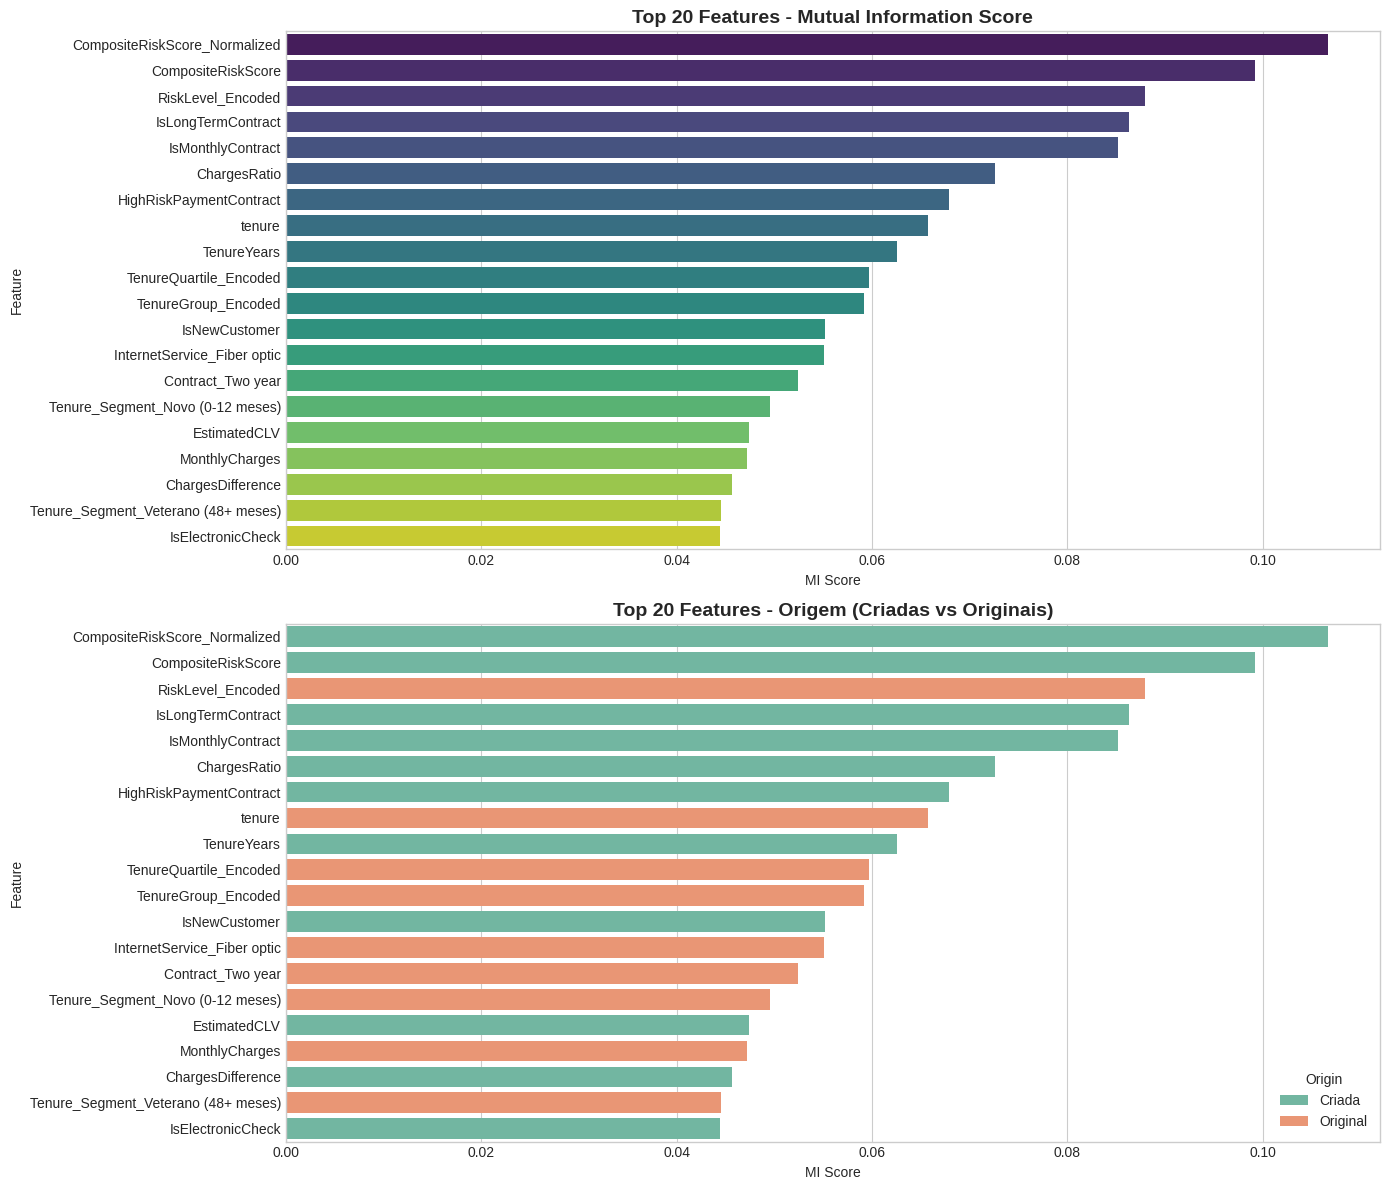

In [90]:
# Criar visualização consolidada
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 20 por Mutual Information
top_20_mi = mi_scores_df.head(20)
sns.barplot(x='MI_Score', y='Feature', data=top_20_mi, ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Features - Mutual Information Score', fontweight='bold', fontsize=14)
axes[0].set_xlabel('MI Score')

# Features criadas vs originais
created_features_in_top = [f for f in top_20_mi['Feature'] if f in new_features]
feature_origin = ['Criada' if f in new_features else 'Original' for f in top_20_mi['Feature']]
origin_df = pd.DataFrame({
    'Feature': top_20_mi['Feature'],
    'Origin': feature_origin,
    'Score': top_20_mi['MI_Score']
})

sns.barplot(x='Score', y='Feature', hue='Origin', data=origin_df, ax=axes[1], palette='Set2')
axes[1].set_title('Top 20 Features - Origem (Criadas vs Originais)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('MI Score')

plt.tight_layout()
plt.show()

In [91]:
print(f"\nFeatures criadas no Top 20: {len(created_features_in_top)} ({len(created_features_in_top)/20*100:.0f}%)")
print(f"Features criadas:")
for f in created_features_in_top:
    print(f"  • {f}")


Features criadas no Top 20: 11 (55%)
Features criadas:
  • CompositeRiskScore_Normalized
  • CompositeRiskScore
  • IsLongTermContract
  • IsMonthlyContract
  • ChargesRatio
  • HighRiskPaymentContract
  • TenureYears
  • IsNewCustomer
  • EstimatedCLV
  • ChargesDifference
  • IsElectronicCheck


## Conclusão

----

O que foi realizado:

##### 1. **Criação de 29 novas features** baseadas em:

- Conhecimento de negócio
- Insights do EDA
- Combinações de variáveis existentes

##### 2. **Transformações aplicadas:**

----

- Encoding de categóricas (Label + One-Hot)
- Normalização de numéricas
- Balanceamento de classes (SMOTE)
- Seleção de features (Mutual Information)

##### 3. **Datasets preparados:**

---
- Completo (todas as features)
- Balanceado (SMOTE)
- Selecionado (top features)

## Próximo Notebook:

---

**Notebook 04 - Modeling:**

- Treinar múltiplos algoritmos (Logistic Regression, Random Forest, XGBoost, etc.)

- Avaliar performance (AUC-ROC, Precision, Recall, F1)
- Tuning de hiperparâmetros
- Seleção do melhor modelo
- Análise de feature importance
- Curvas de aprendizado

---

**Notebook 03 Concluído!**